Input:
- Model Parameter
- Serial Interval, Delay Distribution
- Ggf. Calculation r-value (traditional, neural network, lstm)

Output:
- Calculated/Predicted Observation

In [208]:
import torch
from torch import optim
from torch import distributions
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import imageio
import os

In [209]:
#%cd master-thesis

In [210]:
dtype = torch.float32
#device = torch.device("cuda")
df_si_dd = pd.read_csv('data/si_and_dd.csv', sep=';', decimal=',', encoding='utf-8', dtype={'serial_interval': np.float64, 'delay_distr': np.float64})

In [211]:
population = 1000
n = 100
R = 5*torch.rand(n)
si = torch.zeros(n,dtype=dtype)
si[:29] = torch.tensor(df_si_dd['serial_interval'][0:29],dtype=dtype)
dd =  torch.tensor(df_si_dd['delay_distr'][0:n],dtype=dtype)

In [212]:
# Seed initial Infections
newly_infected = torch.zeros(n, dtype=dtype)
# number of newly infected
cumulative_infected = torch.zeros(n,dtype=dtype)
#cumulative number of infected
inmune = torch.zeros(n,dtype=dtype)
St = torch.ones(n,dtype=dtype)  # fraction of susceptible population
effectively_infectious = torch.zeros(n,dtype=dtype)
cero = torch.tensor(0.,dtype=dtype)

In [213]:
num_impute=6
newly_infected[0:num_impute] = torch.tensor(1.,dtype=dtype)
cumulative_infected[1:num_impute] = torch.cumsum(newly_infected[0:num_impute - 1].clone(), dim=0)

inmune[0:num_impute] = cumulative_infected[0:num_impute].clone() #+ vaccine_inmune[0:num_impute].clone()
# TODO: Add vaccine

In [214]:
for t in range(num_impute, n):
        # Update cumulative newly_infected
        cumulative_infected[t] = cumulative_infected[t - 1] + newly_infected[t - 1]
        inmune[t] = cumulative_infected[t] #+ vaccine_inmune[t]
        # Adjusts for portion of pop that are susceptible
        St[t] = torch.maximum(population - inmune[t], cero) / population
        # effective number of infectous individuals
        ni_temp = newly_infected[:t].view(1, 1, -1).clone()
        si_temp = torch.flip(si, (0,))[-t:].view(1, 1, -1)
        effectively_infectious[t] = torch.nn.functional.conv1d(ni_temp, si_temp)

        newly_infected[t] = St[t].clone() * R[t] * effectively_infectious[t].clone()

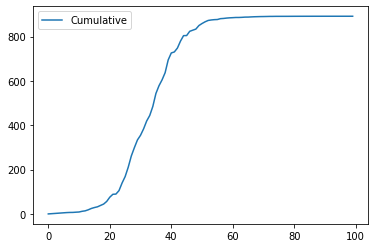

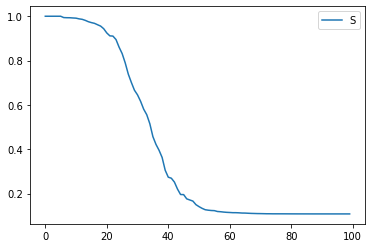

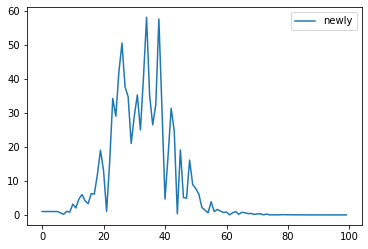

In [215]:
import matplotlib.pyplot as plt
plt.plot(cumulative_infected,label='Cumulative')
plt.legend()
plt.show()
plt.plot(St,label='S')
plt.legend()
plt.show()
plt.plot(newly_infected,label='newly')
plt.legend()
plt.show()